### My Approach to the Internship Task

1. **Understand the problem & business goal**

2. **Load and explore the dataset**

3. **Clean the data**
   - Handle missing values  
   - Treat outliers  
   - Fix multicollinearity  

4. **Perform EDA**
   - Visualize patterns  
   - Compare fraud vs non-fraud  

5. **Select features**
   - Use correlation, model insights, and logic  

6. **Build models**
   - Try multiple algorithms  
   - Tune with cross-validation  

7. **Evaluate models**
   - Use Accuracy, Precision, Recall, F1, AUC-ROC  

8. **Identify key fraud indicators**

9. **Propose prevention strategies**

10. **Plan post-implementation monitoring**

11. **Summarize findings & actionables**


In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, auc

In [2]:
chunksize = 200_000
dfs = []

for chunk in pd.read_csv("C:/Users/HP/Downloads/Fraud.csv", chunksize=chunksize):
    dfs.append(chunk)

df = pd.concat(dfs)

In [4]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: >

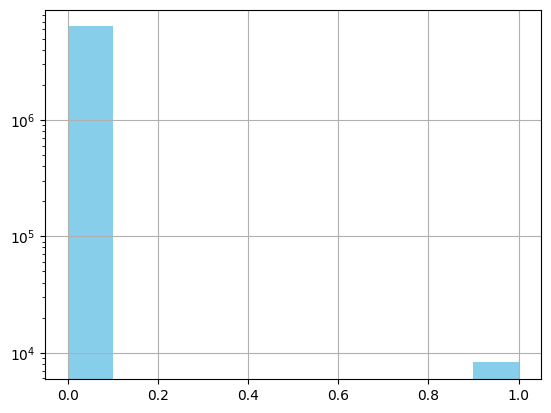

In [7]:
df['isFraud'].hist(log=True, color='skyblue')

In [8]:
# 8213/6354407 = 0.00129

In [9]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
# Storing the categorical and numerical columns

cat_col = df.select_dtypes(include='object').columns
cat_col = [col for col in cat_col]
num_col = df.select_dtypes(exclude='object').columns
num_col = [num for num in num_col]

In [11]:
num_col, cat_col

(['step',
  'amount',
  'oldbalanceOrg',
  'newbalanceOrig',
  'oldbalanceDest',
  'newbalanceDest',
  'isFraud',
  'isFlaggedFraud'],
 ['type', 'nameOrig', 'nameDest'])

In [12]:
# Categorical column's unique value count

for col in cat_col:
    print(df[col].unique(), len(df[col].unique()))

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN'] 5
['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807'] 6353307
['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513'] 2722362


In [13]:
df[num_col].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [14]:
df2 = df.drop(['nameOrig', 'nameDest'], axis=1)
df2.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


1. balanceDiffOrig = oldbalanceOrg - newbalanceOrg
2. balanceDiffDest = newbalanceDest - oldbalanceDest
3. errorOrig = oldbalanceOrg - amount - newbalanceOrg

| `errorOrig` value | Meaning                       | Likely Legit? | Suspected Fraud? |
|-------------------|-------------------------------|----------------|-------------------|
| `== 0`            | Transaction is clean          | ✅ Yes         | ❌ No              |
| `> 0`             | Too much deducted             | ⚠️ Maybe        | ⚠️ Maybe           |
| `< 0`             | Amount not fully deducted     | ❌ No          | ✅ Yes             |

but this data won't help us too much, because all the fraud are happening at `errorOrig == 0`

In [15]:
df2['balanceDiffOrig'] = df2['oldbalanceOrg'] - df2['newbalanceOrig']
df2['balanceDiffDest'] = df2['oldbalanceDest'] - df2['newbalanceDest']
df2['errorOrig'] = df2['oldbalanceOrg'] - df2['amount'] - df2['newbalanceOrig']

In [16]:
df2[df2['errorOrig'] > 0]['isFraud'].value_counts()

isFraud
0    206609
1        36
Name: count, dtype: int64

In [17]:
df2[df2['errorOrig'] == 0]['isFraud'].value_counts()

isFraud
0    940537
1      8086
Name: count, dtype: int64

In [18]:
df2[df2['errorOrig'] < 0]['isFraud'].value_counts()

isFraud
0    5207261
1         91
Name: count, dtype: int64

In [19]:
df2

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,9839.64,0.00,0.0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,1864.28,0.00,0.0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,181.00,0.00,0.0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,181.00,21182.00,0.0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,11668.14,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,339682.13,-339682.13,0.0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,6311409.28,0.00,0.0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,6311409.28,-6311409.27,0.0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,850002.52,0.00,0.0


In [20]:
df2.groupby('type')['isFraud'].value_counts()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: count, dtype: int64

Fraud mostly happening during `CASH_OUT = 4116` AND `TRANSFER = 4097`

In [21]:
df2.groupby(['type', 'isFraud']).size().unstack(fill_value=0)

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


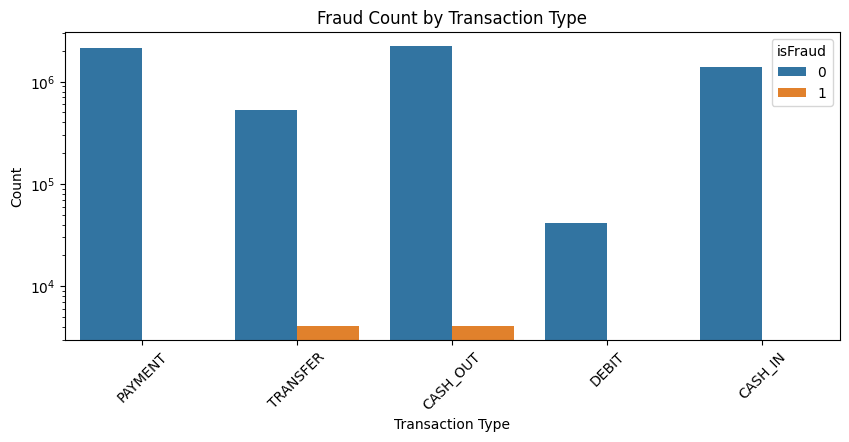

In [22]:
plt.figure(figsize=(10, 4))
sns.countplot(x='type', hue='isFraud', data=df2)
plt.yscale('log', base = 10)
plt.title('Fraud Count by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [23]:
#df2[(df2['type'] == 'TRANSFER') | (df2['type'] == 'CASH_OUT')]
fraud_df = df2[df2['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [24]:
fraud_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,0,181.00,0.00,0.00
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,0,181.00,21182.00,0.00
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0,0,15325.00,-46430.44,-213808.94
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0,0,705.00,22425.00,-214605.30
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0,0,10835.00,-2712905.89,-300850.89
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,0,339682.13,-339682.13,0.00
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,0,6311409.28,0.00,0.00
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0,6311409.28,-6311409.27,0.00
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,0,850002.52,0.00,0.00


In [25]:
fraud_df['isFraud'].value_counts()

isFraud
0    2762196
1       8213
Name: count, dtype: int64

In [26]:
fraud_df[fraud_df['isFraud'] == 1].sample(20)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig
6259962,606,TRANSFER,57588.67,57588.67,0.0,0.00,0.00,1,0,57588.67,0.00,0.0
6362421,727,CASH_OUT,124582.58,124582.58,0.0,320485.06,445067.64,1,0,124582.58,-124582.58,0.0
1059638,111,TRANSFER,3595911.39,3595911.39,0.0,0.00,0.00,1,0,3595911.39,0.00,0.0
6039802,485,TRANSFER,2755588.11,2755588.11,0.0,0.00,0.00,1,0,2755588.11,0.00,0.0
2801110,220,CASH_OUT,285376.60,285376.60,0.0,2719914.68,3005291.27,1,0,285376.60,-285376.59,0.0
1059577,105,CASH_OUT,216351.05,216351.05,0.0,0.00,216351.05,1,0,216351.05,-216351.05,0.0
2986112,231,TRANSFER,400758.85,400758.85,0.0,0.00,0.00,1,0,400758.85,0.00,0.0
2780800,214,CASH_OUT,2582313.07,2582313.07,0.0,1640.53,2583953.60,1,0,2582313.07,-2582313.07,0.0
1068588,120,CASH_OUT,746518.21,746518.21,0.0,348702.45,1095220.66,1,0,746518.21,-746518.21,0.0
6088894,522,TRANSFER,59250.11,59250.11,0.0,0.00,0.00,1,0,59250.11,0.00,0.0


### Fraudulent Transaction Pattern Observations

After analyzing `isFraud == 1` cases in the dataset, two strong patterns emerged:

- In **most fraudulent transactions**, the `newbalanceOrig` is **0**, suggesting the entire balance was transferred out. or
- The `amount` field frequently takes **round values**, often **powers of 10**, indicating premeditated or scripted transaction behavior.

These patterns hint at suspicious activities typically used in money laundering or account takeovers.


In [27]:
fraud_df[(fraud_df['isFraud'] == 1) & (fraud_df['newbalanceOrig'] == 0)]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,0,181.00,0.00,0.0
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,0,181.00,21182.00,0.0
251,1,TRANSFER,2806.00,2806.00,0.0,0.00,0.00,1,0,2806.00,0.00,0.0
252,1,CASH_OUT,2806.00,2806.00,0.0,26202.00,0.00,1,0,2806.00,26202.00,0.0
680,1,TRANSFER,20128.00,20128.00,0.0,0.00,0.00,1,0,20128.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,0,339682.13,-339682.13,0.0
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,0,6311409.28,0.00,0.0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0,6311409.28,-6311409.27,0.0
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,0,850002.52,0.00,0.0


So out of all `8213` fraud transactions, `8053` or `98%` happened when the newbalanceOrig == 0, meaning the sender’s account got completely drained.

In [28]:
df2

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,9839.64,0.00,0.0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,1864.28,0.00,0.0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,181.00,0.00,0.0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,181.00,21182.00,0.0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,11668.14,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,339682.13,-339682.13,0.0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,6311409.28,0.00,0.0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,6311409.28,-6311409.27,0.0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,850002.52,0.00,0.0


<Axes: xlabel='amount', ylabel='isFraud'>

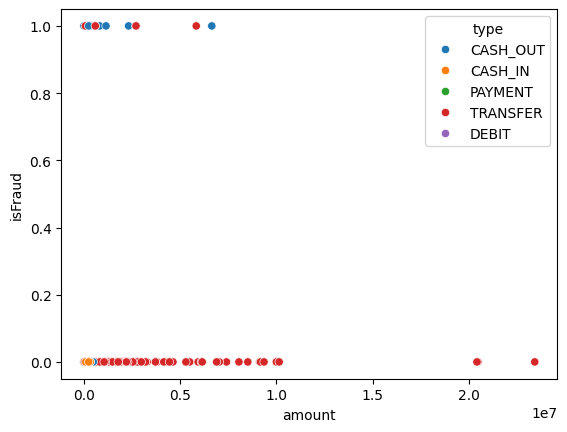

In [29]:
sns.scatterplot(data=df2.sample(10000), x='amount', y='isFraud', hue='type')

In [30]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(data=df2,  # sample for speed
                x='amount', 
                y='newbalanceOrig', 
                hue='isFraud', 
                alpha=0.5, 
                palette={0: 'green', 1: 'red'})
plt.title("Transaction Amount vs New Balance (Orig) — Fraud Highlighted")
plt.xlabel("Amount")
plt.ylabel("New Balance of Origin Account")
plt.yscale('log')  # to deal with large spread
plt.xscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(data=df2,  # sample for speed\n                x=\'amount\', \n                y=\'newbalanceOrig\', \n                hue=\'isFraud\', \n                alpha=0.5, \n                palette={0: \'green\', 1: \'red\'})\nplt.title("Transaction Amount vs New Balance (Orig) — Fraud Highlighted")\nplt.xlabel("Amount")\nplt.ylabel("New Balance of Origin Account")\nplt.yscale(\'log\')  # to deal with large spread\nplt.xscale(\'log\')\nplt.grid(True, linestyle=\'--\', alpha=0.5)\nplt.show()'

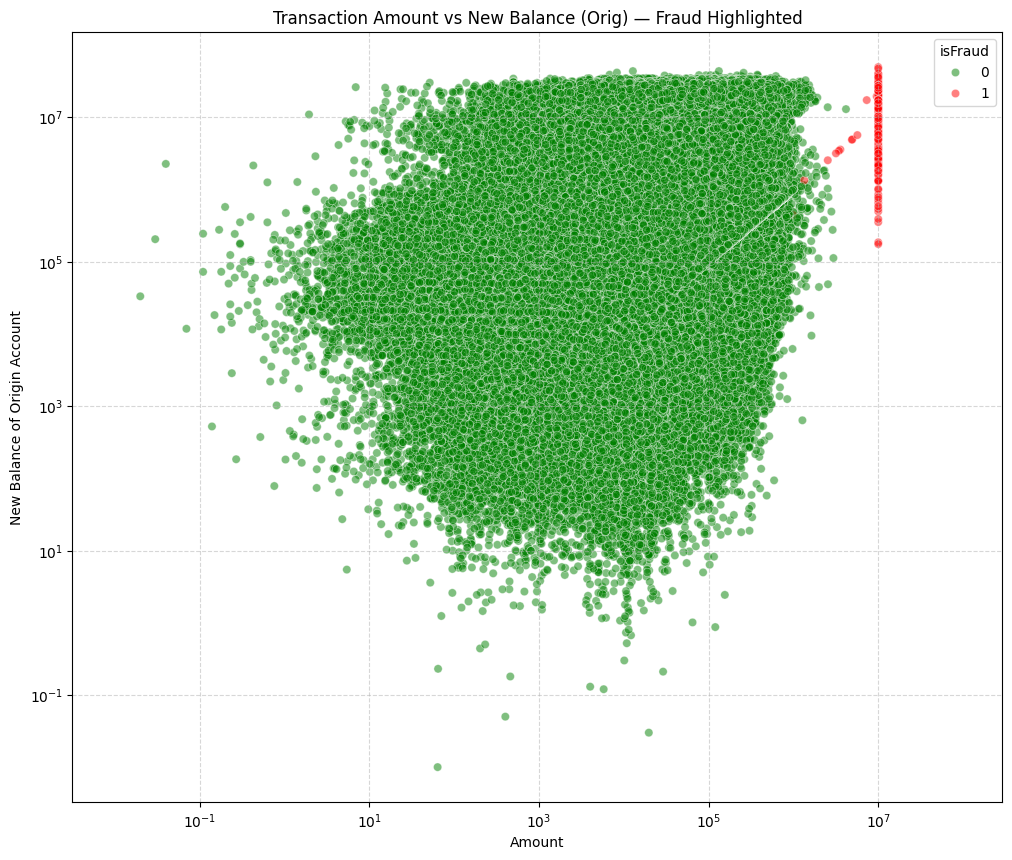

In [31]:
Q1 = df2['amount'].quantile(0.25)
Q3 = df2['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df2[(df2['amount'] < lower_bound) | (df2['amount'] > upper_bound)]

In [32]:
print(outliers['isFraud'].value_counts())
outliers

isFraud
0    334224
1      3854
Name: count, dtype: int64


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig
85,1,TRANSFER,1505626.01,0.00,0.0,29031.00,5515763.34,0,0,0.00,-5486732.34,-1505626.01
86,1,TRANSFER,554026.99,0.00,0.0,579285.56,0.00,0,0,0.00,579285.56,-554026.99
88,1,TRANSFER,761507.39,0.00,0.0,1280036.23,19169204.93,0,0,0.00,-17889168.70,-761507.39
89,1,TRANSFER,1429051.47,0.00,0.0,2041543.62,19169204.93,0,0,0.00,-17127661.31,-1429051.47
93,1,TRANSFER,583848.46,0.00,0.0,667778.00,2107778.11,0,0,0.00,-1440000.11,-583848.46
...,...,...,...,...,...,...,...,...,...,...,...,...
6362613,743,CASH_OUT,1258818.82,1258818.82,0.0,503464.50,1762283.33,1,0,1258818.82,-1258818.83,0.00
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,0,6311409.28,0.00,0.00
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0,6311409.28,-6311409.27,0.00
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,0,850002.52,0.00,0.00


In [33]:
from scipy.stats import zscore

df2['z_amount'] = zscore(df2['amount'])
outliers = df2[df2['z_amount'].abs() > 3]
print(outliers['isFraud'].value_counts())
outliers

isFraud
0    43259
1     1686
Name: count, dtype: int64


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig,z_amount
359,1,TRANSFER,2421578.09,0.00,0.00,8515645.77,19169204.93,0,0,0.00,-10653559.16,-2421578.09,3.712322
375,1,TRANSFER,2545478.01,0.00,0.00,12394437.40,19169204.93,0,0,0.00,-6774767.53,-2545478.01,3.917503
376,1,TRANSFER,2061082.82,0.00,0.00,14939915.42,19169204.93,0,0,0.00,-4229289.51,-2061082.82,3.115336
1153,1,TRANSFER,3776389.09,0.00,0.00,10138670.86,16874643.09,0,0,0.00,-6735972.23,-3776389.09,5.955914
1202,1,TRANSFER,2258388.15,0.00,0.00,2784129.27,4619798.56,0,0,0.00,-1835669.29,-2258388.15,3.442077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362584,741,TRANSFER,5674547.89,5674547.89,5674547.89,0.00,0.00,1,1,0.00,0.00,-5674547.89,9.099299
6362598,742,TRANSFER,4009058.39,4009058.39,0.00,0.00,0.00,1,0,4009058.39,0.00,0.00,6.341218
6362599,742,CASH_OUT,4009058.39,4009058.39,0.00,1229761.96,5238820.34,1,0,4009058.39,-4009058.38,0.00,6.341218
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,6311409.28,0.00,0.00,10.153953


In [34]:
df3 = df2[df2['z_amount'].abs() <= 3]

In [35]:
print(df3['isFraud'].value_counts())
df3

isFraud
0    6311148
1       6527
Name: count, dtype: int64


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig,z_amount
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,9839.64,0.00,0.0,-0.281560
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,1864.28,0.00,0.0,-0.294767
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,181.00,0.00,0.0,-0.297555
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,181.00,21182.00,0.0,-0.297555
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,11668.14,0.00,0.0,-0.278532
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362613,743,CASH_OUT,1258818.82,1258818.82,0.00,503464.50,1762283.33,1,0,1258818.82,-1258818.83,0.0,1.786772
6362614,743,TRANSFER,339682.13,339682.13,0.00,0.00,0.00,1,0,339682.13,0.00,0.0,0.264665
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,339682.13,-339682.13,0.0,0.264665
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,850002.52,0.00,0.0,1.109765


In [36]:
cols = ['amount',	'oldbalanceOrg',	'newbalanceOrig',	'oldbalanceDest']

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'hori

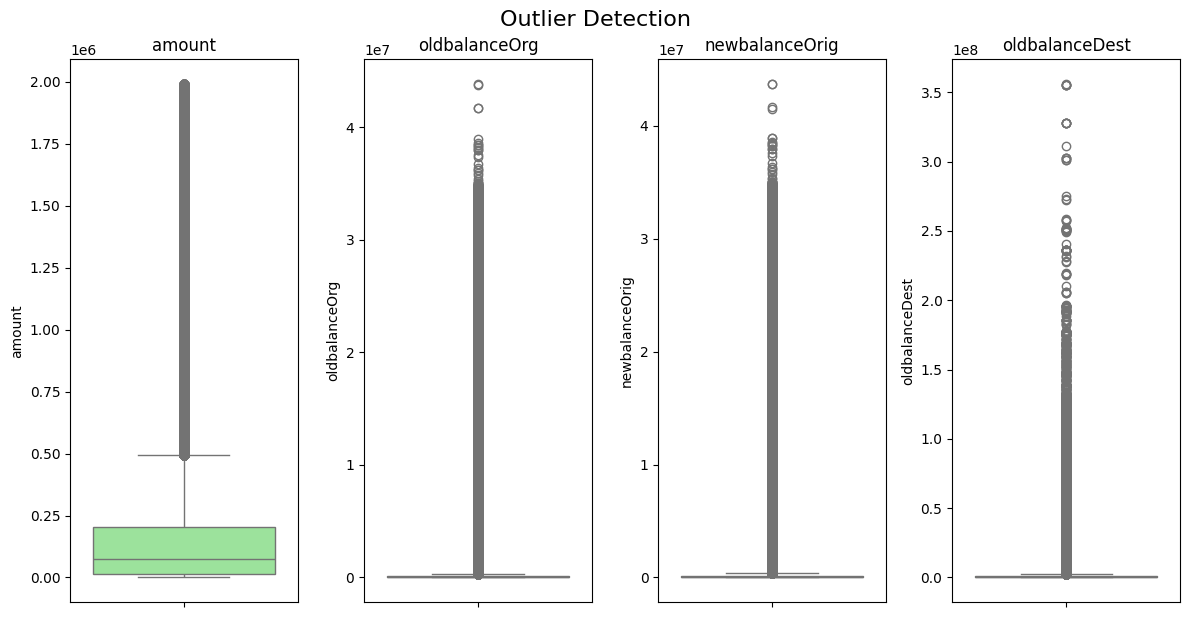

In [37]:
# Plotting
cols = ['amount',	'oldbalanceOrg',	'newbalanceOrig',	'oldbalanceDest']
plt.figure(figsize=(12, 6))
for i, col in enumerate(cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(data=df3, y=col, color='lightgreen')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Outlier Detection", fontsize=16, y=1.02)
plt.show()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


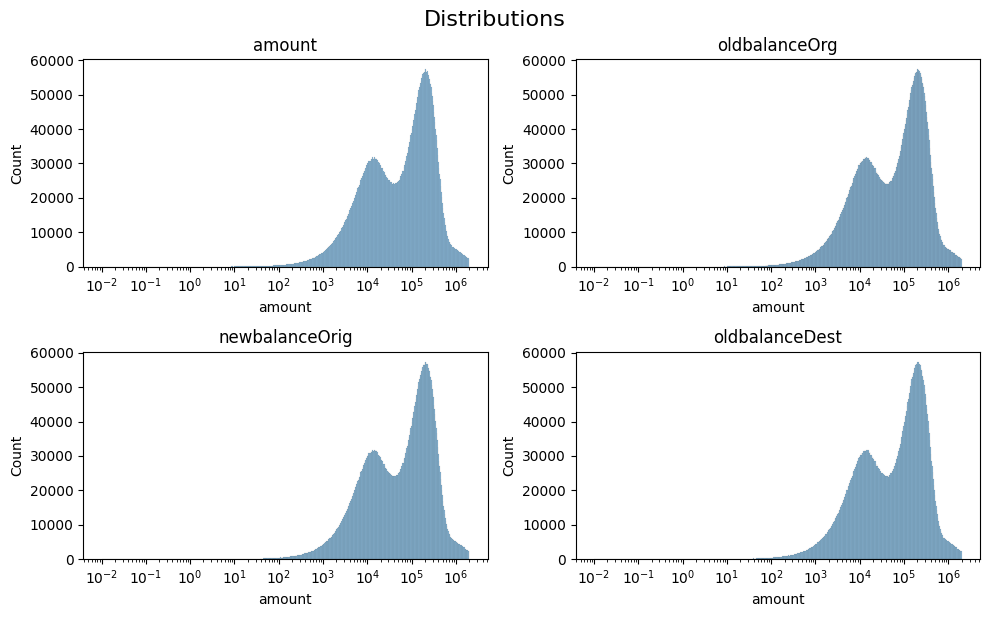

In [38]:
# Plotting
cols = ['amount',	'oldbalanceOrg',	'newbalanceOrig',	'oldbalanceDest']
plt.figure(figsize=(10, 6))
for i, col in enumerate(cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df3['amount'], kde=True, log_scale=10)
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Distributions", fontsize=16, y=1.02)
plt.show()

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


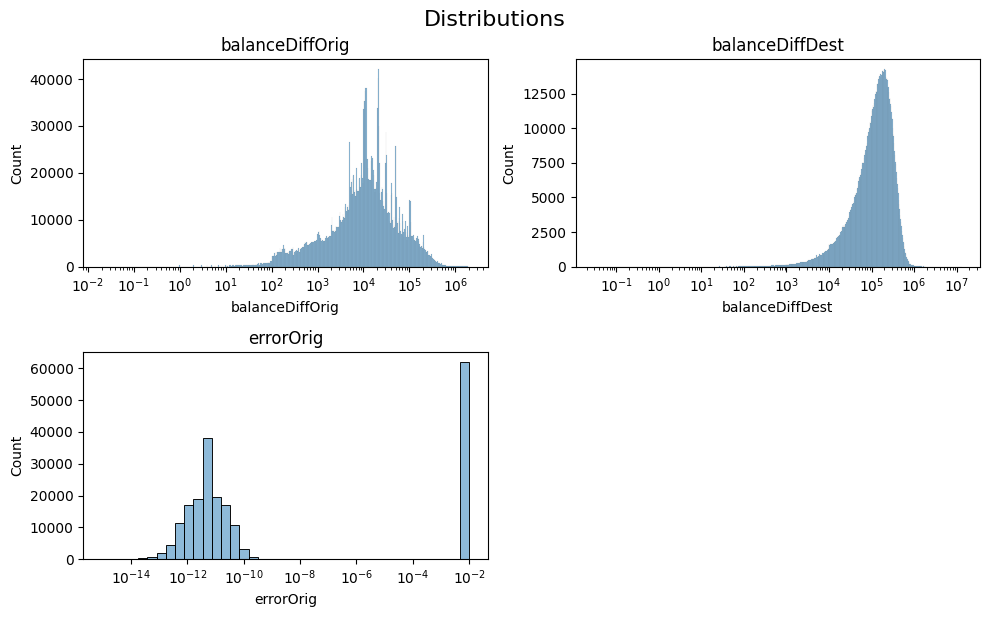

In [39]:
cols = ['balanceDiffOrig',	'balanceDiffDest',	'errorOrig']

plt.figure(figsize=(10, 6))
for i, col in enumerate(cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df3[col], kde=True, log_scale=10)
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Distributions", fontsize=16, y=1.02)
plt.show()

In [40]:
outliers =  df3[(
    ((df['oldbalanceOrg'] == 0) & (df['amount'] > 0)) |
    (df['newbalanceOrig'] == df['oldbalanceOrg']) |
    ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] > 1e7))
)]

print(outliers['isFraud'].value_counts())
outliers

C:\Users\HP\AppData\Local\Temp\ipykernel_39900\920829913.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers =  df3[(


isFraud
0    2079765
1         45
Name: count, dtype: int64


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig,z_amount
29,1,PAYMENT,9920.52,0.0,0.0,0.00,0.00,0,0,0.0,0.00,-9920.52,-0.281426
30,1,PAYMENT,3448.92,0.0,0.0,0.00,0.00,0,0,0.0,0.00,-3448.92,-0.292143
31,1,PAYMENT,4206.84,0.0,0.0,0.00,0.00,0,0,0.0,0.00,-4206.84,-0.290888
32,1,PAYMENT,5885.56,0.0,0.0,0.00,0.00,0,0,0.0,0.00,-5885.56,-0.288108
33,1,PAYMENT,5307.88,0.0,0.0,0.00,0.00,0,0,0.0,0.00,-5307.88,-0.289065
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6356052,709,CASH_OUT,123403.11,0.0,0.0,606875.62,730278.74,0,0,0.0,-123403.12,-123403.11,-0.093497
6356244,709,PAYMENT,14499.40,0.0,0.0,0.00,0.00,0,0,0.0,0.00,-14499.40,-0.273843
6362461,730,CASH_OUT,0.00,0.0,0.0,1008609.53,1008609.53,1,0,0.0,0.00,0.00,-0.297855
6362463,730,CASH_OUT,0.00,0.0,0.0,0.00,0.00,1,0,0.0,0.00,0.00,-0.297855


In [41]:
df3[df['amount'] > 1000000]

C:\Users\HP\AppData\Local\Temp\ipykernel_39900\2227871569.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3[df['amount'] > 1000000]


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig,z_amount
85,1,TRANSFER,1505626.01,0.00,0.0,29031.00,5515763.34,0,0,0.00,-5486732.34,-1505626.01,2.195489
89,1,TRANSFER,1429051.47,0.00,0.0,2041543.62,19169204.93,0,0,0.00,-17127661.31,-1429051.47,2.068680
94,1,TRANSFER,1724887.05,0.00,0.0,3470595.10,19169204.93,0,0,0.00,-15698609.83,-1724887.05,2.558589
358,1,TRANSFER,1538200.39,0.00,0.0,6977445.38,19169204.93,0,0,0.00,-12191759.55,-1538200.39,2.249433
360,1,TRANSFER,1349670.68,0.00,0.0,1538085.96,5515763.34,0,0,0.00,-3977677.38,-1349670.68,1.937224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362575,740,CASH_OUT,1755647.81,1755647.81,0.0,2930014.23,4685662.04,1,0,1755647.81,-1755647.81,0.00,2.609530
6362602,742,TRANSFER,1819543.69,1819543.69,0.0,0.00,0.00,1,0,1819543.69,0.00,0.00,2.715342
6362603,742,CASH_OUT,1819543.69,1819543.69,0.0,0.00,1819543.69,1,0,1819543.69,-1819543.69,0.00,2.715342
6362612,743,TRANSFER,1258818.82,1258818.82,0.0,0.00,0.00,1,0,1258818.82,0.00,0.00,1.786772


In [42]:
dummies = pd.get_dummies(df3['type'])
df3 = pd.concat([df3, dummies], axis=1)

In [43]:
df3.tail()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig,z_amount,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
6362613,743,CASH_OUT,1258818.82,1258818.82,0.0,503464.50,1762283.33,1,0,1258818.82,-1258818.83,0.0,1.786772,False,True,False,False,False
6362614,743,TRANSFER,339682.13,339682.13,0.0,0.00,0.00,1,0,339682.13,0.00,0.0,0.264665,False,False,False,False,True
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,0,339682.13,-339682.13,0.0,0.264665,False,True,False,False,False
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,0,850002.52,0.00,0.0,1.109765,False,False,False,False,True
6362619,743,CASH_OUT,850002.52,850002.52,0.0,6510099.11,7360101.63,1,0,850002.52,-850002.52,0.0,1.109765,False,True,False,False,False


In [44]:
df4 = df3.drop(['type', 'z_amount'], axis=1)

In [45]:
df4 = df4.reset_index(drop=True)
print(df4['isFraud'].value_counts())
df4

isFraud
0    6311148
1       6527
Name: count, dtype: int64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,9839.64,0.00,0.0,False,False,False,True,False
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,1864.28,0.00,0.0,False,False,False,True,False
2,1,181.00,181.00,0.00,0.00,0.00,1,0,181.00,0.00,0.0,False,False,False,False,True
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,181.00,21182.00,0.0,False,True,False,False,False
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,11668.14,0.00,0.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6317670,743,1258818.82,1258818.82,0.00,503464.50,1762283.33,1,0,1258818.82,-1258818.83,0.0,False,True,False,False,False
6317671,743,339682.13,339682.13,0.00,0.00,0.00,1,0,339682.13,0.00,0.0,False,False,False,False,True
6317672,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,339682.13,-339682.13,0.0,False,True,False,False,False
6317673,743,850002.52,850002.52,0.00,0.00,0.00,1,0,850002.52,0.00,0.0,False,False,False,False,True


### Summary of Bad, Good, and Excellent Models from my POV (Based on 8,213 Frauds)
Actual data ~ 6.3 Millions and Actual Frauds ~ 8.2 Thousands

| **Model Type**        | **Recall**        | **FN %**              | **Fraud Detected (TP)** | **Fraud Missed (FN)** |
|-----------------------|-------------------|------------------------|-------------------------|-----------------------|
| **Bad Model**         | Below 60%         | More than 40%          | Less than **4,928**      | More than **3,285**    |
| **Good Model**        | 60% to 80%        | 20% to 40%             | **4,928 – 6,570**        | **1,643 – 3,285**      |
| **Excellent Model**   | 80% to 95%        | 5% to 20%              | **6,570 – 7,802**        | **411 – 1,643**        |
| **Outstanding Model** | Above 95%         | Less than 5%           | More than **7,802**      | Less than **411**      |



In [46]:
X = df4.drop('isFraud', axis=1)
y = df4['isFraud']
X.shape, y.shape

((6317675, 15), (6317675,))

In [47]:
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,errorOrig,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,9839.64,0.00,0.0,False,False,False,True,False
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,1864.28,0.00,0.0,False,False,False,True,False
2,1,181.00,181.00,0.00,0.00,0.00,0,181.00,0.00,0.0,False,False,False,False,True
3,1,181.00,181.00,0.00,21182.00,0.00,0,181.00,21182.00,0.0,False,True,False,False,False
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,11668.14,0.00,0.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6317670,743,1258818.82,1258818.82,0.00,503464.50,1762283.33,0,1258818.82,-1258818.83,0.0,False,True,False,False,False
6317671,743,339682.13,339682.13,0.00,0.00,0.00,0,339682.13,0.00,0.0,False,False,False,False,True
6317672,743,339682.13,339682.13,0.00,0.00,339682.13,0,339682.13,-339682.13,0.0,False,True,False,False,False
6317673,743,850002.52,850002.52,0.00,0.00,0.00,0,850002.52,0.00,0.0,False,False,False,False,True


In [48]:
from sklearn.model_selection import train_test_split

# Sample 1 million rows from the full dataset with stratification (to preserve fraud ratio)
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=1_000_000, stratify=y, random_state=42)

# Now split this 1M into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, stratify=y_sampled, random_state=42)

# Quick sanity check
print(f"Train size X: {X_train.shape}, Test size X: {X_test.shape}")
print(f"Train frauds y: {y_train.shape}, Test frauds y: {y_test.shape}")

Train size X: (800000, 15), Test size X: (200000, 15)
Train frauds y: (800000,), Test frauds y: (200000,)


In [49]:
print(y_train.value_counts())
print(y_test.value_counts())

isFraud
0    799174
1       826
Name: count, dtype: int64
isFraud
0    199793
1       207
Name: count, dtype: int64


In [50]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [51]:
y_res.value_counts()

isFraud
0    799174
1    799174
Name: count, dtype: int64

In [52]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, auc

## Models

In [53]:
lr_model = LogisticRegression(C=0.01, solver = 'liblinear', class_weight='balanced')
lr_model.fit(X_train, y_train)
print(lr_model.score(X_res, y_res))
cm = confusion_matrix(y_test, lr_model.predict(X_test))
print(cm)

0.9804010140470035
[[193909   5884]
 [     7    200]]


In [54]:
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

# Evaluate metrics for class 1 (fraud)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)  # use probabilities for AUC!

# Print results
print(f"Recall (Fraud):     {recall:.4f}")
print(f"Precision (Fraud):  {precision:.4f}")
print(f"F1 Score:           {f1:.4f}")
print(f"AUC-ROC Score:      {auc_roc:.4f}")

Recall (Fraud):     0.9662
Precision (Fraud):  0.0329
F1 Score:           0.0636
AUC-ROC Score:      0.9899


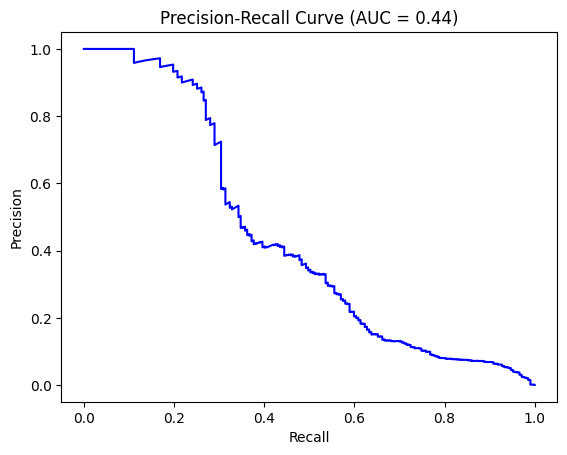

In [55]:
y_scores = lr_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()

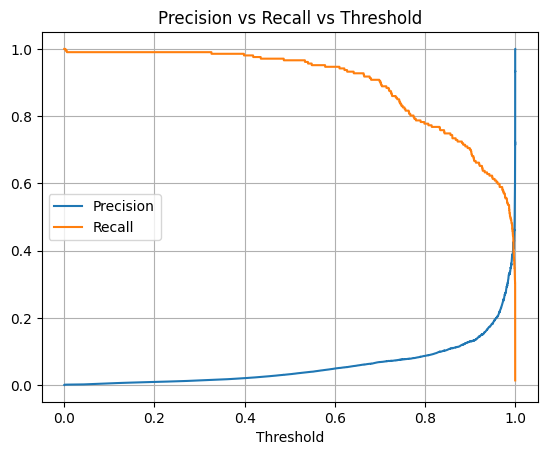

In [56]:
y_scores = lr_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Plotting threshold vs precision/recall
import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid(True)
plt.title('Precision vs Recall vs Threshold')
plt.show()

In [57]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
print(rf_model.score(X_res, y_res))
cm = confusion_matrix(y_test, rf_model.predict(X_test))
print(cm)

0.9978102390718416
[[199793      0]
 [     2    205]]


In [58]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate metrics for class 1 (fraud)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)  # using probabilities for AUC!

print(f"Recall (Fraud):     {recall:.4f}")
print(f"Precision (Fraud):  {precision:.4f}")
print(f"F1 Score:           {f1:.4f}")
print(f"AUC-ROC Score:      {auc_roc:.4f}")

Recall (Fraud):     0.9903
Precision (Fraud):  1.0000
F1 Score:           0.9951
AUC-ROC Score:      0.9938


*Random Forest Model*
| **Metric**              | **With Feature Engineering** | **Without Feature Engineering** |
|-------------------------|------------------------------|---------------------------------|
| **Recall (Fraud)**       | 0.9903                       | 0.9420                          |
| **Precision (Fraud)**    | 1.0000                       | 0.0197                          |
| **F1 Score**             | 0.9951                       | 0.0386                          |
| **AUC-ROC Score**        | 0.9938                       | 0.9914                          |

## `errorOrig` might be data leakage here


Feature Importances:
            Feature  Importance
9         errorOrig    0.370389
7   balanceDiffOrig    0.135995
2     oldbalanceOrg    0.099667
3    newbalanceOrig    0.098514
13          PAYMENT    0.068001
14         TRANSFER    0.047040
8   balanceDiffDest    0.046193
1            amount    0.045291
0              step    0.043800
4    oldbalanceDest    0.014193
5    newbalanceDest    0.012367
11         CASH_OUT    0.011551
10          CASH_IN    0.005949
12            DEBIT    0.001050
6    isFlaggedFraud    0.000000


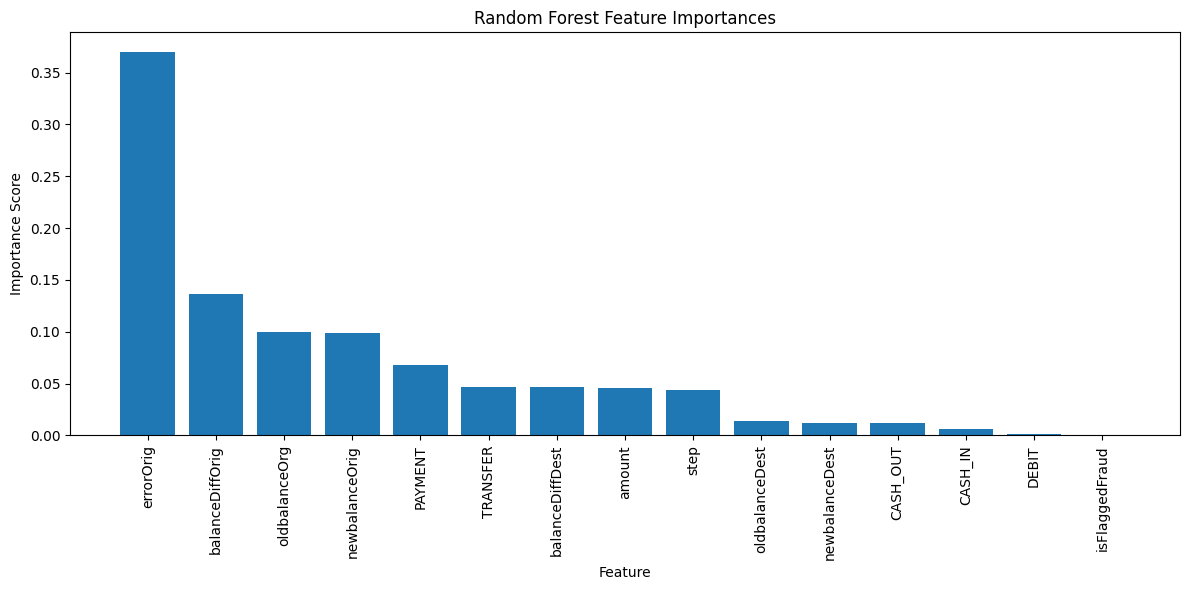

In [ ]:
# 
feature_importances = rf_model.feature_importances_
feature_names = X_res.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.title('Random Forest Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

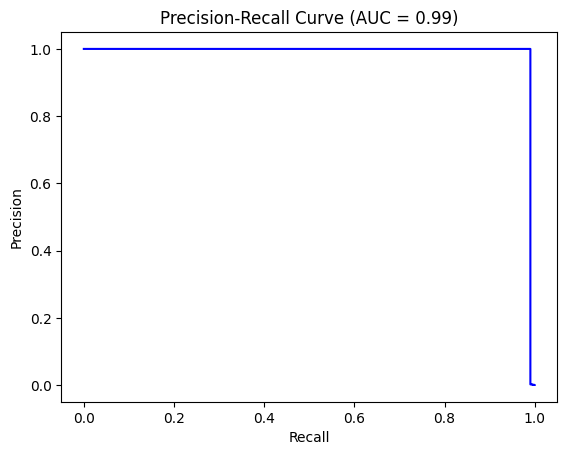

In [64]:
y_scores = rf_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()

In [65]:
dt_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
print(dt_model.score(X_res, y_res))
cm = confusion_matrix(y_test, dt_model.predict(X_test))
print(cm)

0.9978114903638007
[[199791      2]
 [     2    205]]


In [60]:
y_pred = dt_model.predict(X_test)
y_proba = dt_model.predict_proba(X_test)[:, 1]

# Evaluate metrics for class 1 (fraud)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)  # use probabilities for AUC!

# Print results
print(f"Recall (Fraud):     {recall:.4f}")
print(f"Precision (Fraud):  {precision:.4f}")
print(f"F1 Score:           {f1:.4f}")
print(f"AUC-ROC Score:      {auc_roc:.4f}")

Recall (Fraud):     0.9903
Precision (Fraud):  0.9903
F1 Score:           0.9903
AUC-ROC Score:      0.9952


*Decision Tree Model*
| **Metric**               | **With Feature Engineering** | **Without Feature Engineering** |
|--------------------------|------------------------------|---------------------------------|
| **Recall (Fraud)**        | 0.9903                       | 0.9614                          |
| **Precision (Fraud)**     | 0.9903                       | 0.0425                          |
| **F1 Score**              | 0.9903                       | 0.0815                          |
| **AUC-ROC Score**         | 0.9952                       | 0.9743                          |
